In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
import plotly
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf

In [3]:
# Importation des données du Bitcoin
btc_hist_data = yf.download('BTC-USD', period='max')

btc_hist_data.index = pd.to_datetime(btc_hist_data.index, unit='s')


# Séparation du target avec les autres caractéristiques
target_btc = btc_hist_data['Close']

btc_hist = btc_hist_data.drop(['Close'], axis=1)

target_column = "Close"

btc_hist.head(5)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [8]:
seeds = 58
def t_t_split(df, seeds, t_size=0.2):
    # split_row = len(df) - int(test_size * len(df))
    # train_data = df.iloc[:split_row]
    # test_data = df.iloc[split_row:]
    train_data, test_data = train_test_split(df, test_size = t_size,random_state=seeds)
    return train_data, test_data
train, test = t_t_split(btc_hist_data, seeds, t_size=0.2)

# Forcer le maintien de la division du datastet à chaquue exécution

# test_size=  0.2
# # train et test split
# btc_train, btc_test, target_train, target_test = train_test_split(
#         btc_hist, target_btc,
#         test_size=0.2,
#         random_state=seeds
#     )



# # Train et test du datframe initial
# def t_t_split(df, test_size, seeds):
#     btc_train, btc_test,d,f = train_test_split(df,df, test_size=test_size, random_state=seeds)
#     return btc_train, btc_test
# train, test = t_t_split(btc_hist_data, test_size,seeds)

3438 3438


2750

TypeError: Axes.scatter() missing 1 required positional argument: 'y'

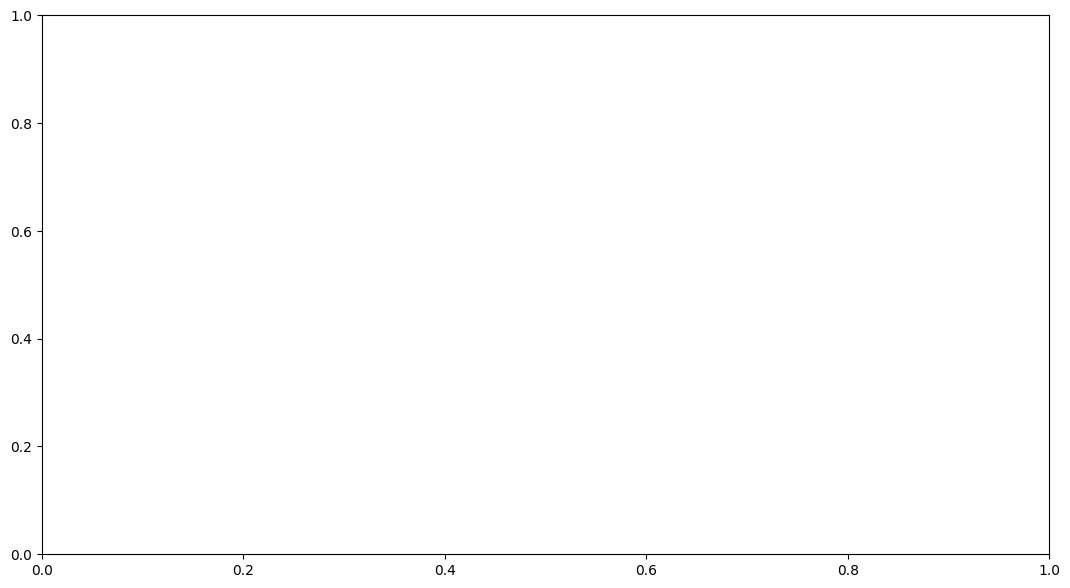

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_column], test[target_column], 'training', 'test', title='')

In [99]:
def normaliser_zero_base(dataframe):
    return dataframe / dataframe.iloc[0] - 1

# Noramliser les données en utilisant le MinMax
def normaliser_min_max(dataframe):
    return (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())

# Extraire des fenêtres de données de taille 5
def extract_window_data(dataframe, window_lenght=5, zero_base=True):
    window_data = []
    for index in range(len(dataframe) - window_lenght):
        temp_save = dataframe[index: (index + window_lenght)].copy()
        if zero_base:
            temp_save = normaliser_zero_base(temp_save)
        window_data.append(temp_save.values)
    return np.array(window_data)

# # Noramlisation
# scaler = StandardScaler()
# btc_hist_normalised = scaler.fit_transform(btc_hist)

# print(btc_hist_normalised.mean())
# print(btc_hist_normalised.std())

# btc_hist_normalised
# ff = (btc_hist - btc_hist.mean())
# tt = btc_hist.std()
# ff = ff/tt
# print(ff.head(5))
# print(ff.mean())

# # Noramlisation avec MinMaxScaler
# min_max_scaler = MinMaxScaler()
# btc_hist_min_max_norm = min_max_scaler.fit_transform(btc_hist)
# print(btc_hist_min_max_norm)

In [100]:
# La préparation des données 

# def prepare_data(btc_train, btc_test, target_train, target_test):
def prepare_data(btc_hist, target_btc, target_column, window_len=10, zero_base=True):
    train_data, test_data = btc_hist, target_btc
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_column][window_len:].values
    y_test = test_data[target_column][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_column][:-window_len].values - 1
        y_test = y_test / test_data[target_column][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
# return btc_train, btc_test, target_train, target_test

In [101]:
#La construction du modèle en LSTM
def lstm_model_building(input_data, output_size, neurons=300, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons,  input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# btc_train.shape[1]

In [102]:
# Les informations desquelles nous nous servirions pour l'utilisation du modèle
np.random.seed(seeds)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 200
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [103]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(train, test, target_column, window_len=window_len, zero_base=True)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=seeds)


model = lstm_model_building(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
btc_history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_data=(X_val, y_val))

(2194,)
Epoch 1/200
138/138 [==============================] - 5s 17ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 2/200
138/138 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/200
138/138 [==============================] - 2s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/200
138/138 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/200
138/138 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/200
138/138 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/200
138/138 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/200
138/138 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/200
138/138 [==============================] - 1s 7ms/step - loss: 0.0

(2748, 6) (686, 6) (2194, 5, 6) (681, 5, 6) (2194,) (681,)


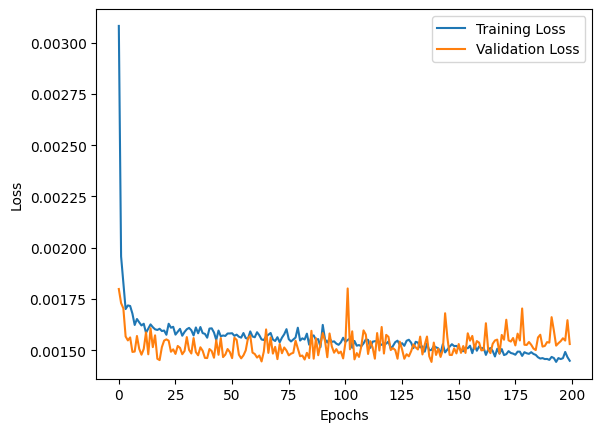

In [104]:
print(train_data.shape, test_data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape )
# Afficher la courbe de la perte
plt.plot(btc_history.history['loss'], label='Training Loss')
plt.plot(btc_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# print(btc_history[history])

In [105]:
targets = test[target_column][window_len:]
targets =  pd.DataFrame({
    f"{target_column}" : targets
})
preds = model.predict(X_test).squeeze()
print("Moyenne de l'errreur absolue", mean_absolute_error(preds, y_test))
print(targets)


22/22 [==============================] - 1s 3ms/step
Moyenne de l'errreur absolue 0.019494112731725403
                   Close
Date                    
2022-04-01  46281.644531
2022-04-02  45868.949219
2022-04-03  46453.566406
2022-04-04  46622.675781
2022-04-05  45555.992188
...                  ...
2024-02-06  43084.671875
2024-02-07  44318.222656
2024-02-08  45301.566406
2024-02-09  47147.199219
2024-02-10  47986.597656

[681 rows x 1 columns]


In [106]:
mean_preds = (np.mean(preds))
mean_preds

0.0012985019

In [107]:
# print(test[target_column].values[:-window_len] * (preds + 1))
preds = test[target_column].values[:-window_len] * (preds + 1)

preds = pd.DataFrame(
    data = {f'{target_column}':preds}, 
    index= targets.index
)
# preds = pd.Series(index=targets.index, data=preds)

print(preds)
# line_plot(targets, preds[target_column], 'Valeurs réelles', 'prediction', lw=3)

                   Close
Date                    
2022-04-01  45682.445431
2022-04-02  46211.383476
2022-04-03  45791.196592
2022-04-04  46279.425968
2022-04-05  46587.351997
...                  ...
2024-02-06  42338.531708
2024-02-07  42904.147152
2024-02-08  44686.031103
2024-02-09  45534.870295
2024-02-10  47606.109645

[681 rows x 1 columns]


In [108]:
# Créez un DataFrame avec ces deux séries en tant que colonnes
data = {'Valeurs exactes': targets[target_column], 'Valeurs prédites': preds[target_column]}
compare = pd.DataFrame(data, index=targets.index)

# Affichez le DataFrame
print(compare)

            Valeurs exactes  Valeurs prédites
Date                                         
2022-04-01     46281.644531      45682.445431
2022-04-02     45868.949219      46211.383476
2022-04-03     46453.566406      45791.196592
2022-04-04     46622.675781      46279.425968
2022-04-05     45555.992188      46587.351997
...                     ...               ...
2024-02-06     43084.671875      42338.531708
2024-02-07     44318.222656      42904.147152
2024-02-08     45301.566406      44686.031103
2024-02-09     47147.199219      45534.870295
2024-02-10     47986.597656      47606.109645

[681 rows x 2 columns]


In [109]:
# Prédire pour plusieurs jours à venir
num_days_to_predict = 7  # Ajustez le nombre de jours à prédire selon vos besoins

# Création d'un dataframe qui contiendra Les valeurs prédites et leurs dates correspondantes
predicted_values_close = pd.DataFrame({})
predicted_date = []
predicted_val_close = []
future_dates = pd.date_range(btc_hist_data.index[-1], periods=num_days_to_predict+1, freq='D')[1:]  # Générer les dates futures
future_dates = pd.to_datetime(future_dates)
btc_change = btc_hist_data
for future_date in future_dates:

    future_data = pd.DataFrame({'Open': np.mean(btc_change.iloc[-seeds:]['Open']) * (mean_preds+1), 'High': np.mean(btc_change.iloc[-seeds:]['High']) * (mean_preds+1), 'Low': np.mean(btc_change.iloc[-seeds:]['Low']) * (mean_preds+1), 'Close': np.mean(btc_change.iloc[-seeds:]['Close']) * (mean_preds+1), 'Adj Close': np.mean(btc_change.iloc[-seeds:]['Adj Close']) * (mean_preds+1), 'Volume': np.mean(btc_change.iloc[-seeds:]['Volume']) * (mean_preds+1)}, index=[future_date])
    btc_change = pd.concat((btc_change, future_data), axis=0)
    

    # future_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.transform(future_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
    # future_data_sequence = future_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values.reshape(-1, 5, 6)
    # # Faire la prédiction pour le jour suivant
    # predicted_close = model.predict(future_data_sequence)
    # predicted_close = scaler.inverse_transform(predicted_close.reshape(1, -1))[0, 0]
    # ...
    # Faire la prédiction pour le jour suivant

    # Ajout dans le dataframe qui contiendra Les valeurs prédites et leurs dates correspondantes

    #predicted_close = model.predict(future_data)
# a,b,pred_train, pred_test, test_train, test_test = prepare_data()   
future_data.shape
    
    # predicted_date.append(future_date)
    # predicted_val_close.append(predicted_close)
    # print(f"Prédiction du prix de clôture pour {future_date.date()}: {predicted_close}")

(1, 6)

In [110]:
######### Essai aevc les données générées avec la moynne

train_btc, test_btc = t_t_split(btc_change, test_size=0.2)
test_btc.tail(5)

,Open,High,Low,Close,Adj Close,Volume
2024-02-13,43099.065588,43917.807855,42336.637087,43201.737601,43201.737601,2.425738e+10
2024-02-14,43113.963463,43944.710187,42354.972833,43233.452411,43233.452411,2.438822e+10
2024-02-15,43144.447138,43965.848173,42386.474288,43243.981813,43243.981813,2.437378e+10
2024-02-16,43153.129698,43976.405852,42396.144386,43260.787305,43260.787305,2.439454e+10
2024-02-17,43168.526025,43971.240877,42399.119416,43254.029184,43254.029184,2.433456e+10


In [111]:
train_btc_data, test_btc_data, X_btc_train, X_btc_test, y_btc_train, y_btc_test = prepare_data(train_btc, test_btc, target_column, window_len=window_len, zero_base=True)
X_btc_train, X_btc_val, y_btc_train, y_btc_val= train_test_split(X_btc_train, y_btc_train, test_size=0.2, random_state=seeds)
print(y_train.shape)

(2194,)


In [112]:
targets_btc = test_btc[target_column][window_len:]
targets_btc =  pd.DataFrame({
    f"{target_column}" : targets_btc
})
preds_btc = model.predict(X_btc_test).squeeze()
print("Moyenne de l'errreur absolue", mean_absolute_error(preds_btc, y_btc_test))
print(targets_btc)


# print(test[target_column].values[:-window_len] * (preds + 1))
preds_btc = test_btc[target_column].values[:-window_len] * (preds_btc + 1)

preds_btc = pd.DataFrame(
    data = {f'{target_column}':preds_btc}, 
    index= targets_btc.index
)
# preds = pd.Series(index=targets.index, data=preds)

print(preds_btc)
# line_plot(targets, preds[target_column], 'Valeurs réelles', 'prediction', lw=3)


# Créez un DataFrame avec ces deux séries en tant que colonnes
data_btc = {'Valeurs exactes': targets_btc[target_column], 'Valeurs prédites': preds_btc[target_column]}
compare_btc = pd.DataFrame(data_btc, index=targets_btc.index)

# Affichez le DataFrame
print(compare_btc)

22/22 [==============================] - 0s 3ms/step
Moyenne de l'errreur absolue 0.019569524913340786
                   Close
2022-04-06  43206.738281
2022-04-07  43503.847656
2022-04-08  42287.664062
2022-04-09  42782.136719
2022-04-10  42207.671875
...                  ...
2024-02-13  43201.737601
2024-02-14  43233.452411
2024-02-15  43243.981813
2024-02-16  43260.787305
2024-02-17  43254.029184

[683 rows x 1 columns]
                   Close
2022-04-06  45324.506542
2022-04-07  43235.607296
2022-04-08  43295.855486
2022-04-09  42412.255231
2022-04-10  42655.201429
...                  ...
2024-02-13  42471.949324
2024-02-14  43416.051015
2024-02-15  43856.628541
2024-02-16  43188.853612
2024-02-17  43206.262814

[683 rows x 1 columns]
            Valeurs exactes  Valeurs prédites
2022-04-06     43206.738281      45324.506542
2022-04-07     43503.847656      43235.607296
2022-04-08     42287.664062      43295.855486
2022-04-09     42782.136719      42412.255231
2022-04-10     4220

In [113]:
compare_btc.tail(8)

,Valeurs exactes,Valeurs prédites
2024-02-10,47986.597656,47606.109645
2024-02-11,43164.108601,47964.129835
2024-02-12,43185.418145,43518.846012
2024-02-13,43201.737601,42471.949324
2024-02-14,43233.452411,43416.051015
2024-02-15,43243.981813,43856.628541
2024-02-16,43260.787305,43188.853612
2024-02-17,43254.029184,43206.262814


In [114]:
btc_change['Close'].tail(8)

2024-02-10    47986.597656
2024-02-11    43164.108601
2024-02-12    43185.418145
2024-02-13    43201.737601
2024-02-14    43233.452411
2024-02-15    43243.981813
2024-02-16    43260.787305
2024-02-17    43254.029184
Name: Close, dtype: float64

In [115]:
other_test = btc_change.iloc[-7:-1][target_column]

print(other_test)



2024-02-11    43164.108601
2024-02-12    43185.418145
2024-02-13    43201.737601
2024-02-14    43233.452411
2024-02-15    43243.981813
2024-02-16    43260.787305
Name: Close, dtype: float64


In [116]:
preds.index


DatetimeIndex(['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
               '2022-04-09', '2022-04-10',
               ...
               '2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10'],
              dtype='datetime64[ns]', name='Date', length=681, freq=None)

In [117]:
compare.head(10)

,Valeurs exactes,Valeurs prédites
Date,,
2022-04-01,46281.644531,45682.445431
2022-04-02,45868.949219,46211.383476
2022-04-03,46453.566406,45791.196592
2022-04-04,46622.675781,46279.425968
2022-04-05,45555.992188,46587.351997
2022-04-06,43206.738281,45324.506542
2022-04-07,43503.847656,43235.607296
2022-04-08,42287.664062,43295.855486
2022-04-09,42782.136719,42412.255231


In [118]:
compare.describe()

,Valeurs exactes,Valeurs prédites
count,681.000000,681.000000
mean,27726.642440,27722.153630
std,8017.108676,8009.721495
min,15787.284180,15728.529313
25%,21161.519531,21157.747050
50%,26861.707031,26827.166356
75%,30425.857422,30493.550529
max,47986.597656,47606.109645


In [119]:
print(model.predict(X_test))

22/22 [==============================] - 0s 3ms/step
[[-2.43065730e-02]
 [-1.94495730e-02]
 [-3.52787785e-02]
 [-1.66424289e-02]
 [ 2.30282042e-02]
 [-2.06807368e-02]
 [-5.74101508e-02]
 [-6.79756403e-02]
 [-9.03084204e-02]
 [-6.36753142e-02]
 [-3.09033468e-02]
 [-9.14351866e-02]
 [-5.29951677e-02]
 [-3.26373391e-02]
 [-4.49373536e-02]
 [ 2.18917727e-02]
 [-4.54957597e-04]
 [-4.10210565e-02]
 [ 2.12630220e-02]
 [ 2.54377034e-02]
 [ 3.20109203e-02]
 [ 2.51275226e-02]
 [-2.71948613e-02]
 [-5.25671914e-02]
 [-4.74058799e-02]
 [-8.50424077e-03]
 [-3.42381559e-02]
 [-2.22398248e-03]
 [ 1.21408794e-02]
 [-4.66247499e-02]
 [-1.04011772e-02]
 [-1.87337101e-02]
 [-3.49553078e-02]
 [-2.43481547e-02]
 [ 5.65611422e-02]
 [-5.04010022e-02]
 [-6.93233684e-02]
 [-6.93859458e-02]
 [-1.24330290e-01]
 [-1.42489254e-01]
 [-1.33038521e-01]
 [-1.40902147e-01]
 [-1.30648211e-01]
 [-4.53151911e-02]
 [-3.68945226e-02]
 [ 6.41093478e-02]
 [ 1.73262525e-02]
 [ 2.56777722e-02]
 [-4.92574945e-02]
 [-2.51226462e-0

## L'utilisation de la validation


In [120]:
# Enregistrer le modèle de machine learning
import joblib
crypto_predict = model
joblib.dump(crypto_predict, "crypto_course.joblib")

['crypto_course.joblib']

In [133]:
def predict_data(preds_btc):
    preds_btc = preds_btc
    return preds_btc

def btc_data():
    return btc_hist_data

def btc_data_preds(preds):
    btc_d = pd.DataFrame(preds.iloc[-7:])
    return btc_d
   
predict_data = predict_data(preds_btc)
btc_data = btc_data()
btc_data_preds = btc_data_preds(btc_change)

joblib.dump(btc_data_preds, "btc_data_preds.joblib")
joblib.dump(predict_data, "prediction.joblib")
joblib.dump(btc_data, "btc_dataset.joblib")

['btc_dataset.joblib']

In [132]:
btc_data_preds(btc_change)

,Open,High,Low,Close,Adj Close,Volume
2024-02-11,43078.489689,43882.821149,42315.478246,43164.108601,43164.108601,2.401434e+10
2024-02-12,43079.357015,43896.545791,42326.225105,43185.418145,43185.418145,2.408987e+10
2024-02-13,43099.065588,43917.807855,42336.637087,43201.737601,43201.737601,2.425738e+10
2024-02-14,43113.963463,43944.710187,42354.972833,43233.452411,43233.452411,2.438822e+10
2024-02-15,43144.447138,43965.848173,42386.474288,43243.981813,43243.981813,2.437378e+10
2024-02-16,43153.129698,43976.405852,42396.144386,43260.787305,43260.787305,2.439454e+10
2024-02-17,43168.526025,43971.240877,42399.119416,43254.029184,43254.029184,2.433456e+10
